In [1]:
from luxai_s2.env import LuxAI_S2
from luxai_s2.map.board import Board
from luxai_s2.map_generator.generator import GameMap
import matplotlib.pyplot as plt
import matplotlib
import logging
import numpy as np
from luxai_s2.utils import my_turn_to_place_factory
from agents_experiments import (reset_w_custom_board, IdleAgent, ControlledAgent, interact)
from plots import plot_factory_stats, plot_robot_stats
import uuid
from IPython.display import Video
from pprint import pprint
from robots import CartesianPoint, MapPlanner
from plants import ConnCompMapSpawner
from obs import CenteredObservation
import pandas as pd
# import seaborn as sns

matplotlib.rc('font', size=14)
b_ = '/home/adrian_admin/prog/kaggle/lux-ai-2/Lux-Design-S2/data/experiments/adrian/logs/'
exp_num = str(uuid.uuid4())
print('experiment name={}'.format(exp_num))
logging.basicConfig(filename=b_ + exp_num + '.log', level=logging.WARNING)
logger = logging.getLogger()

experiment name=5619fb77-34d0-4be8-8bad-e84f93c7c2b5


In [2]:
env = LuxAI_S2()
SEED = 5
obs = env.reset(seed=SEED)

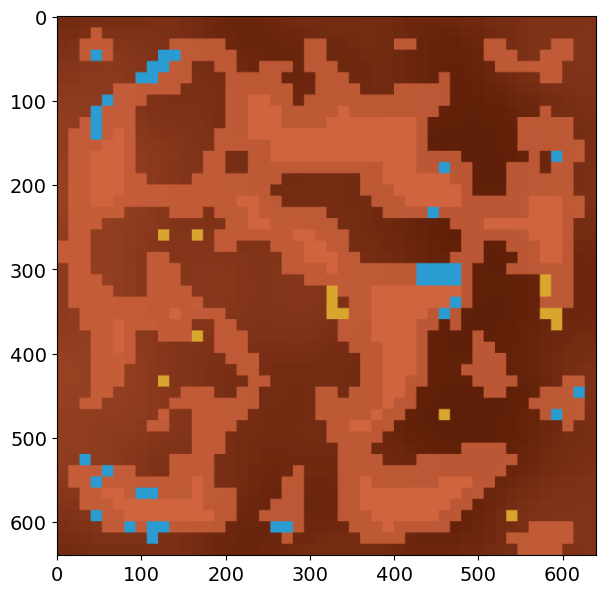

In [3]:
logger.setLevel(logging.WARNING)
img = env.render("rgb_array", width=640, height=640)
f, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img);

In [4]:
# agent = ControlledAgent('player_0', env.state.env_cfg)

In [5]:
logger.setLevel(logging.DEBUG)

filename = exp_num + '.mp4'
file_path = '/home/adrian_admin/prog/kaggle/lux-ai-2/Lux-Design-S2/data/experiments/adrian/'
animate_arg = ''  # file_path + filename

agents = {}
for player, agent_constructor in zip(env.agents, [IdleAgent, ControlledAgent]):
    logging.debug('player{} runs with class{}'.format(player, agent_constructor))
    agents[player] = agent_constructor(player, env.state.env_cfg) 
    
first_obs, last_obs = interact(
    env, 
    agents, 
    4, 
    animate_=animate_arg, 
    break_at_first_action=False, 
    debug=False, 
    custom_board=None,  #simple_board
    seed=SEED
)
# print(last_obs)

In [6]:
logger.setLevel(logging.WARNING)

In [7]:
cobs = CenteredObservation(first_obs['player_1'], 'player_1')
cobs.my_player_name

'player_1'

In [8]:
# pprint(cobs.dict_obj)

In [9]:
planner = MapPlanner(cobs)

In [10]:
spawner = ConnCompMapSpawner(cobs, threshold=0, rad=30)

In [26]:
[c.area for c in spawner.components]

[20, 5, 42, 1, 78, 3, 8, 20, 17, 1, 28, 2]

In [12]:
from space import identify_conn_components

In [13]:
len(identify_conn_components(cobs.rubble_map))

12

In [14]:
# get potential spawning locs
x, y, z = spawner._get_potential_spawns()
print(type(x),type(y), type(z))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'>


In [15]:
# score them
scores = spawner.score(z)
type(scores)

numpy.ndarray

In [16]:
# summarize results
res = pd.DataFrame({'x': x, 'y': y, 's': scores})
res.shape

(1820, 3)

In [17]:
res = res.sort_values('s', ascending=False)

In [18]:
res.head(30)

,x,y,s
478,14,29,78
434,13,31,78
282,9,17,78
287,9,25,78
529,15,34,78
528,15,33,78
527,15,32,78
526,15,31,78
525,15,30,78
391,12,25,78


In [19]:
res.s.min()

0

In [20]:
# Video(animate_arg, embed=True)

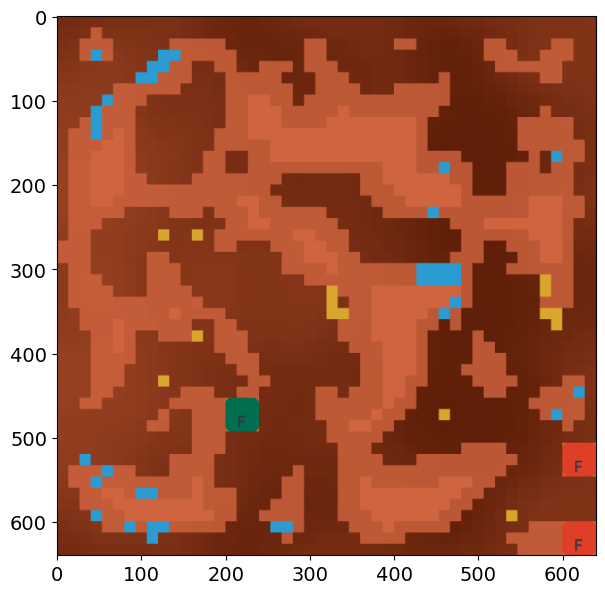

In [21]:
#video above is missing bottom pixels for some reason 
logger.setLevel(logging.INFO)
img = env.render("rgb_array", width=640, height=640)
f, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img);

In [23]:
cobs2 = CenteredObservation(last_obs[cobs.my_player_name], cobs.my_player_name)
cobs2.my_factories

{'factory_1': {'pos': array([16, 35]),
  'power': 1000,
  'cargo': {'ice': 0, 'ore': 0, 'water': 150, 'metal': 150},
  'unit_id': 'factory_1',
  'strain_id': 1,
  'team_id': 1}}

In [24]:
res.loc[(res.x == 16) & (res.y == 35)]

,x,y,s
576,16,35,78


In [25]:
res.loc[(res.x == 35) & (res.y == 16)]

,x,y,s
1355,35,16,0


In [ ]:
# res.loc[res.x == 16].sort_values('y')

In [ ]:
# logger.setLevel(logging.INFO)
# plot_robot_stats(agents['player_1'].stats);

In [ ]:
# plot_factory_stats(agents['player_1'].stats);